In [1]:
%reload_ext autoreload
%autoreload 2

import os
import re
from glob import glob
import numpy as np
import pandas as pd
from scipy import signal
from sklearn import metrics
from imblearn.ensemble import BalancedRandomForestClassifier
from hmmlearn import hmm
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import features
import hmm_utils

np.random.seed(42)

## Setup

In [2]:
SAMPLE_RATE = 100  # Hz
WINDOW_SEC = 5  # seconds
STEPTOL = 2  # count
WINDOW_LEN = int(WINDOW_SEC * SAMPLE_RATE)  # ticks

In [3]:
# --------------------------
#   Some utility functions
# --------------------------

def read_csv(filename):
    """ Data loader """

    data = pd.read_csv(
        filename, 
        parse_dates=['timestamp'], 
        index_col='timestamp',
        dtype={
            'x': 'f4', 
            'y': 'f4', 
            'z': 'f4', 
            'annotation': 'i2',
        }
    )
    return data


def plotw(w, ax, lp=5, find_peaks=False, find_peaks_params=None):
    """ Plot a window accel trace """

    v = np.linalg.norm(w[['x', 'y', 'z']].to_numpy(), axis=1)  # absolute accel magnitude
    v = v - 1  # detrend: "remove gravity"

    if lp:
        # lowpass filter
        v = features.butterfilt(v, lp, SAMPLE_RATE)

    xanno = np.argwhere(w['annotation'].to_numpy()).ravel()
    yanno = v[xanno]
    ax.plot(v)
    ax.scatter(xanno, yanno, marker='x', c='k', label='step')
    title = f"steps: {len(xanno)}"

    if find_peaks:
        find_peaks_params = find_peaks_params or {}
        peaks, _ = signal.find_peaks(v, **find_peaks_params)
        ax.scatter(peaks, v[peaks], marker='o', fc='none', ec='r', label='find_peaks')
        title = f"{title} | find_peaks: {len(peaks)}"

    ax.grid(True)
    ax.legend()
    ax.set_title(title)
    return ax


#### Visuals

Always good idea to do some data inspection

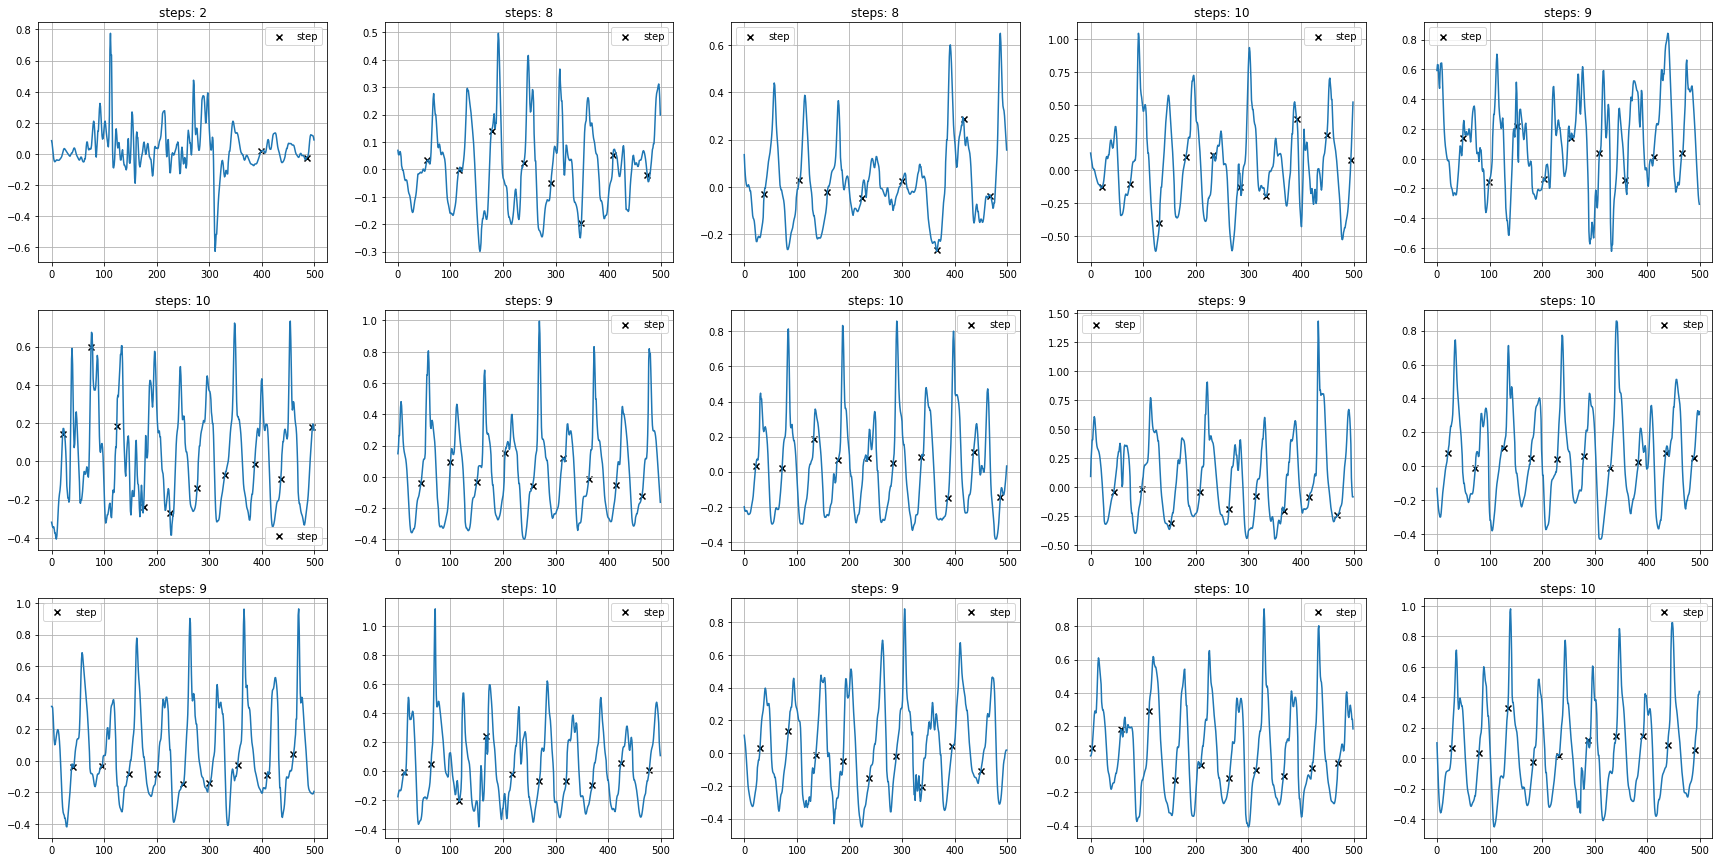

In [4]:
data = read_csv("data/oxwalk/P01_wrist100.csv")

NFIGS = 15
fig, axs = plt.subplots(ncols=NFIGS//3, nrows=3, figsize=(30, 15))
n = 0
for i, w in data.resample(f"{WINDOW_SEC}s"):
    if w['annotation'].sum() >= STEPTOL:
        plotw(w, axs.flat[n], lp=None)
        n += 1
    if n >= NFIGS: break

fig.show()

## Walk detection model

### Feature extraction

In [5]:
def make_windows(data, window_sec=WINDOW_SEC, sample_rate=SAMPLE_RATE):
    """ Split data into windows, extract features and assign labels """

    X_raw = []
    X_feats = []

    window_len = int(window_sec * sample_rate)

    for i, w in data.resample(f"{window_sec}s"):

        if len(w) < window_len:
            continue

        steps = w['annotation'].sum()
        is_walk = int(steps >= STEPTOL)
        steps *= is_walk  # only count if it's a walk window
        xyz = w[['x', 'y', 'z']].to_numpy()

        X_raw.append(xyz)

        X_feats.append({
            'time': w.index[0],
            **features.extract_features(xyz, sample_rate),
            'steps': steps,
            'is_walk': is_walk,
        })

    X_raw = np.stack(X_raw)
    X_feats = pd.DataFrame(X_feats)

    return X_raw, X_feats

In [6]:
X = []
feats = []

for filename in tqdm(glob("data/oxwalk/*.csv")):

    data = read_csv(filename)
    _X_raw, _X_feats = make_windows(data)
    pid = re.search(r'(P\d{2})', os.path.basename(filename)).group(1).upper()  # P01, P02, ...
    _X_feats['pid'] = pid

    X.append(_X_raw)
    feats.append(_X_feats)

X = np.concatenate(X)
feats = pd.concat(feats)

display(feats)
print("X shape:", X.shape)

# Save for future use
np.save("X.npy", X)
feats.to_pickle("feats.pkl")

  0%|          | 0/39 [00:00<?, ?it/s]

,time,min,q25,med,q75,max,autocorr_halfsec,autocorr_onesec,autocorr_twosec,pentropy,...,f2,p1,p2,npeaks,peaks_med_promin,peaks_min_promin,peaks_max_promin,steps,is_walk,pid
0,2019-07-22 14:05:40,-0.179092,-0.031363,-0.000993,0.032858,0.129207,0.225611,-0.054159,-0.043247,3.198406,...,1.666667,0.001844,0.001064,0,0.000000,0.000000,0.000000,0,0,P17
1,2019-07-22 14:05:45,-0.286582,-0.040598,0.003275,0.049919,0.598546,0.059471,0.230903,-0.290282,2.972866,...,1.333333,0.003415,0.003322,2,0.552617,0.583062,0.613507,0,0,P17
2,2019-07-22 14:05:50,-0.300211,-0.020633,0.003881,0.030592,0.456092,-0.022886,-0.106845,0.078480,3.490850,...,7.666667,0.000433,0.000251,1,0.320811,0.320811,0.320811,0,0,P17
3,2019-07-22 14:05:55,-0.353397,-0.028437,0.004325,0.041937,0.438064,-0.156648,0.168534,0.201387,3.363926,...,2.000000,0.004051,0.003373,2,0.268917,0.288370,0.307824,0,0,P17
4,2019-07-22 14:06:00,-0.230990,-0.016522,0.012428,0.047403,0.266536,0.053579,-0.151273,-0.092973,3.026292,...,1.666667,0.001900,0.001422,0,0.000000,0.000000,0.000000,0,0,P17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
714,2019-07-22 22:09:55,-0.014945,-0.008271,-0.004366,-0.001083,0.008135,0.298545,0.250796,0.175355,3.817195,...,9.000000,0.000005,0.000003,0,0.000000,0.000000,0.000000,0,0,P28
715,2019-07-22 22:10:00,-0.015448,-0.003215,-0.001697,0.001679,0.013663,-0.016611,0.148262,0.046451,3.753468,...,1.666667,0.000007,0.000003,0,0.000000,0.000000,0.000000,0,0,P28
716,2019-07-22 22:10:05,-0.016636,-0.004039,-0.002705,-0.002253,0.009991,0.046047,-0.163884,0.046179,3.903075,...,13.333333,0.000002,0.000002,0,0.000000,0.000000,0.000000,0,0,P28
717,2019-07-22 22:10:10,-0.412400,-0.048774,-0.007314,0.021025,0.860308,-0.152208,-0.188542,0.022330,2.207974,...,1.666667,0.011890,0.002514,2,0.395263,0.527881,0.660499,0,0,P28


X shape: (27239, 500, 3)


### Random forest

In [7]:
# Train/Test split

test_pids = np.random.choice(feats['pid'].unique(), size=10, replace=False)
feats_test = feats[feats['pid'].isin(test_pids)]
feats_train = feats[~feats['pid'].isin(test_pids)]

print("Test PIDs:", test_pids)
print("Train frame shape:", feats_train.shape)
print("Test frame shape:", feats_test.shape)

Test PIDs: ['P20' 'P23' 'P33' 'P38' 'P25' 'P08' 'P13' 'P03' 'P34' 'P30']
Train frame shape: (20301, 21)
Test frame shape: (6938, 21)


In [8]:
not_feats_cols = ['time', 'pid', 'is_walk', 'steps']

X_train = feats_train.drop(columns=not_feats_cols).to_numpy()
Y_train = feats_train['is_walk'].to_numpy()

clf = BalancedRandomForestClassifier(
    n_estimators=1000,
    replacement=True,
    sampling_strategy='not minority',
    oob_score=True,
    n_jobs=4,
    random_state=42,
    verbose=1
)
clf.fit(X_train, Y_train)

X_test = feats_test.drop(columns=not_feats_cols).to_numpy()
Y_test = feats_test['is_walk'].to_numpy()
pid_test = feats_test['pid'].to_numpy()

Y_test_pred = clf.predict(X_test)

print(metrics.classification_report(Y_test, Y_test_pred))


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    6.0s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    7.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s


              precision    recall  f1-score   support

           0       0.97      0.94      0.95      4081
           1       0.92      0.95      0.94      2857

    accuracy                           0.95      6938
   macro avg       0.94      0.95      0.94      6938
weighted avg       0.95      0.95      0.95      6938



[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.4s finished


### Hidden Markov model with known emission

The emission probability is essentially just the classifier's error rate.

In [9]:
hmms = hmm_utils.HMMSmoother().fit(clf, Y_train)
# Note: To do this more properly we should 
# groupby pid and pass each sequence one by one
Y_test_pred_hmm = hmms.predict(Y_test_pred)
print(metrics.classification_report(Y_test, Y_test_pred_hmm))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      4081
           1       0.93      0.96      0.94      2857

    accuracy                           0.95      6938
   macro avg       0.95      0.95      0.95      6938
weighted avg       0.95      0.95      0.95      6938



### Hidden Markov model with known emission _and_ transition

An alternative way to apply HMM is to use the in-sample transition probabilities.  

Note that this may yield an optimistic biased estimate of performance if the
current dataset is sufficiently homogeneous. Transition probabilities in healthy
populations may differ from transition probabilities in disease populations.


In [10]:
params = hmm_utils.train_hmm(clf.oob_decision_function_, Y_train)
# Note: To do this more properly we should 
# groupby pid and pass each sequence one by one
Y_test_pred_hmm = hmm_utils.viterbi(Y_test_pred, params)
print(metrics.classification_report(Y_test, Y_test_pred_hmm))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      4081
           1       0.94      0.95      0.95      2857

    accuracy                           0.96      6938
   macro avg       0.95      0.96      0.95      6938
weighted avg       0.96      0.96      0.96      6938



## Step counts

To infer steps from accelerometry, we assume that steps correspond to peaks in acceleration.
This is reasonable: You might recall that conundrum in highschool physics about
instantaneaous collisions resulting in infinite forces.

The main tool will be the peak finding algorithm implemented in `scipy.find_peaks`. 

Let's re-visualize the traces from before, this time enabling peak finding.

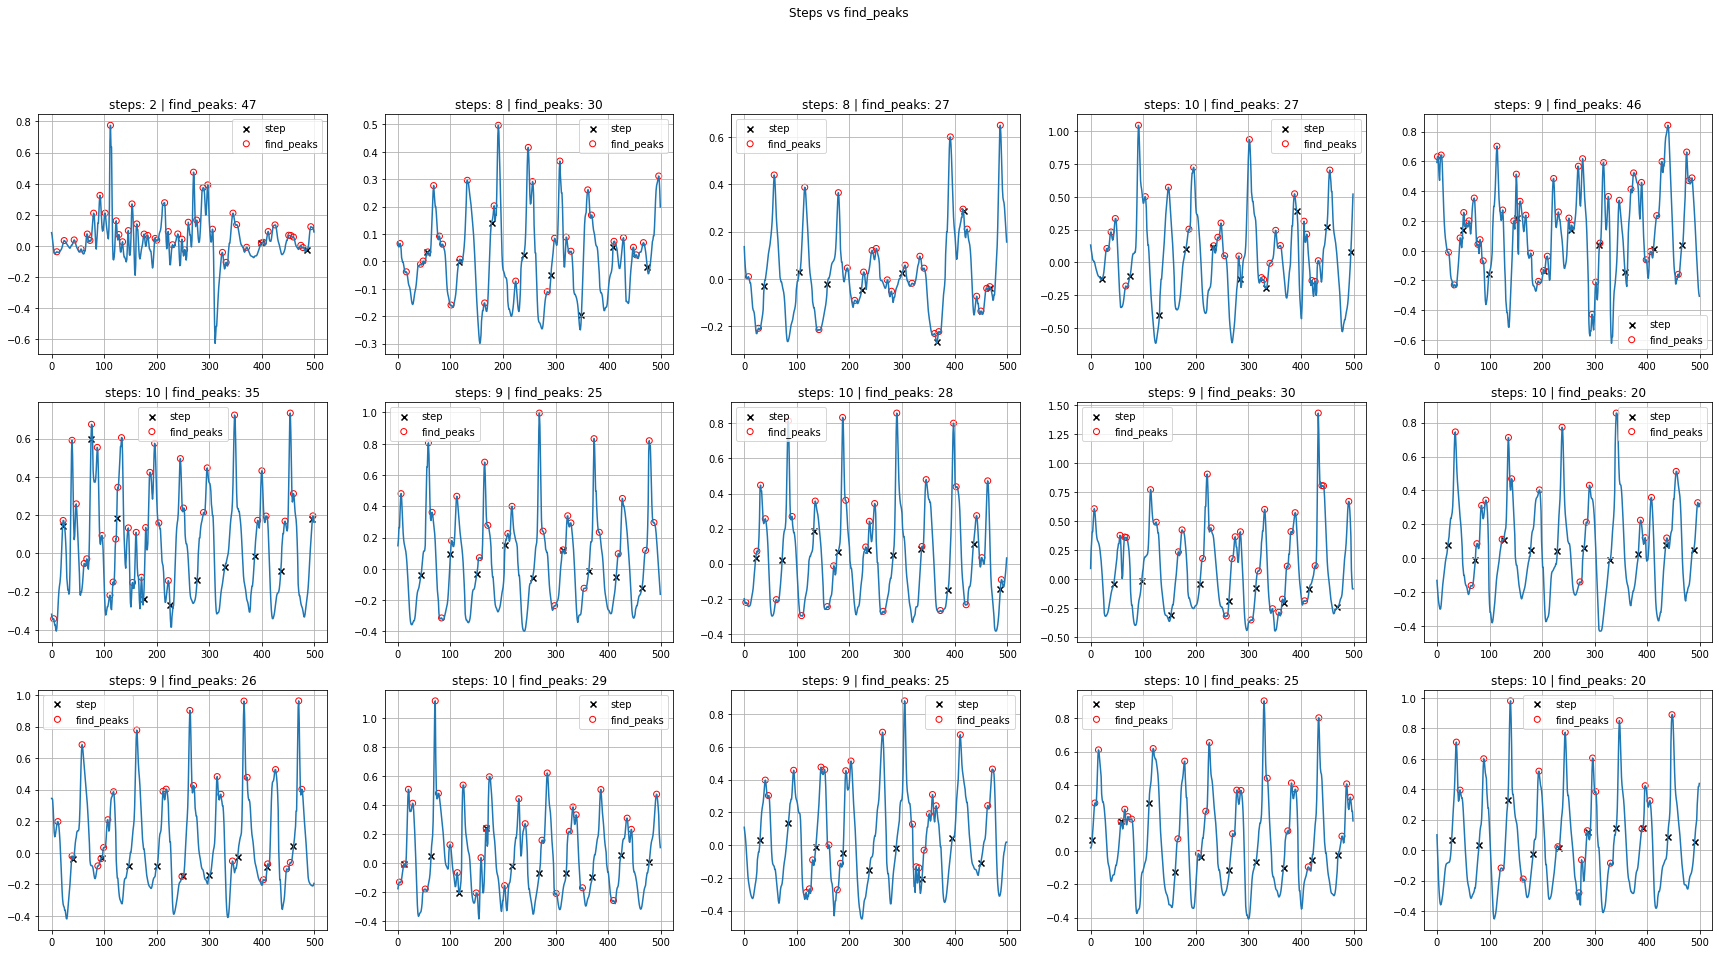

In [11]:
data = read_csv("data/oxwalk/P01_wrist100.csv")

NFIGS = 15
fig, axs = plt.subplots(ncols=NFIGS//3, nrows=3, figsize=(30, 15))
n = 0
for i, w in data.resample(f"{WINDOW_SEC}s"):
    if w['annotation'].sum() >= STEPTOL:
        plotw(w, axs.flat[n], lp=None, find_peaks=True)
        n += 1
    if n >= NFIGS: break

fig.suptitle("Steps vs find_peaks")
fig.show()

Peak finding with default parameters finds every single peak present in the signal, which is not really what we want.

We can tune the peak finder to only consider peaks that satisfy certain
conditions. Two parameters that we tune are `distance` and `prominence`. The
higher these values, the stricter the peak selection is.

From eyeballing the plots, let's try values 0.1 for `prominence` and 0.2 sec for `distance`.


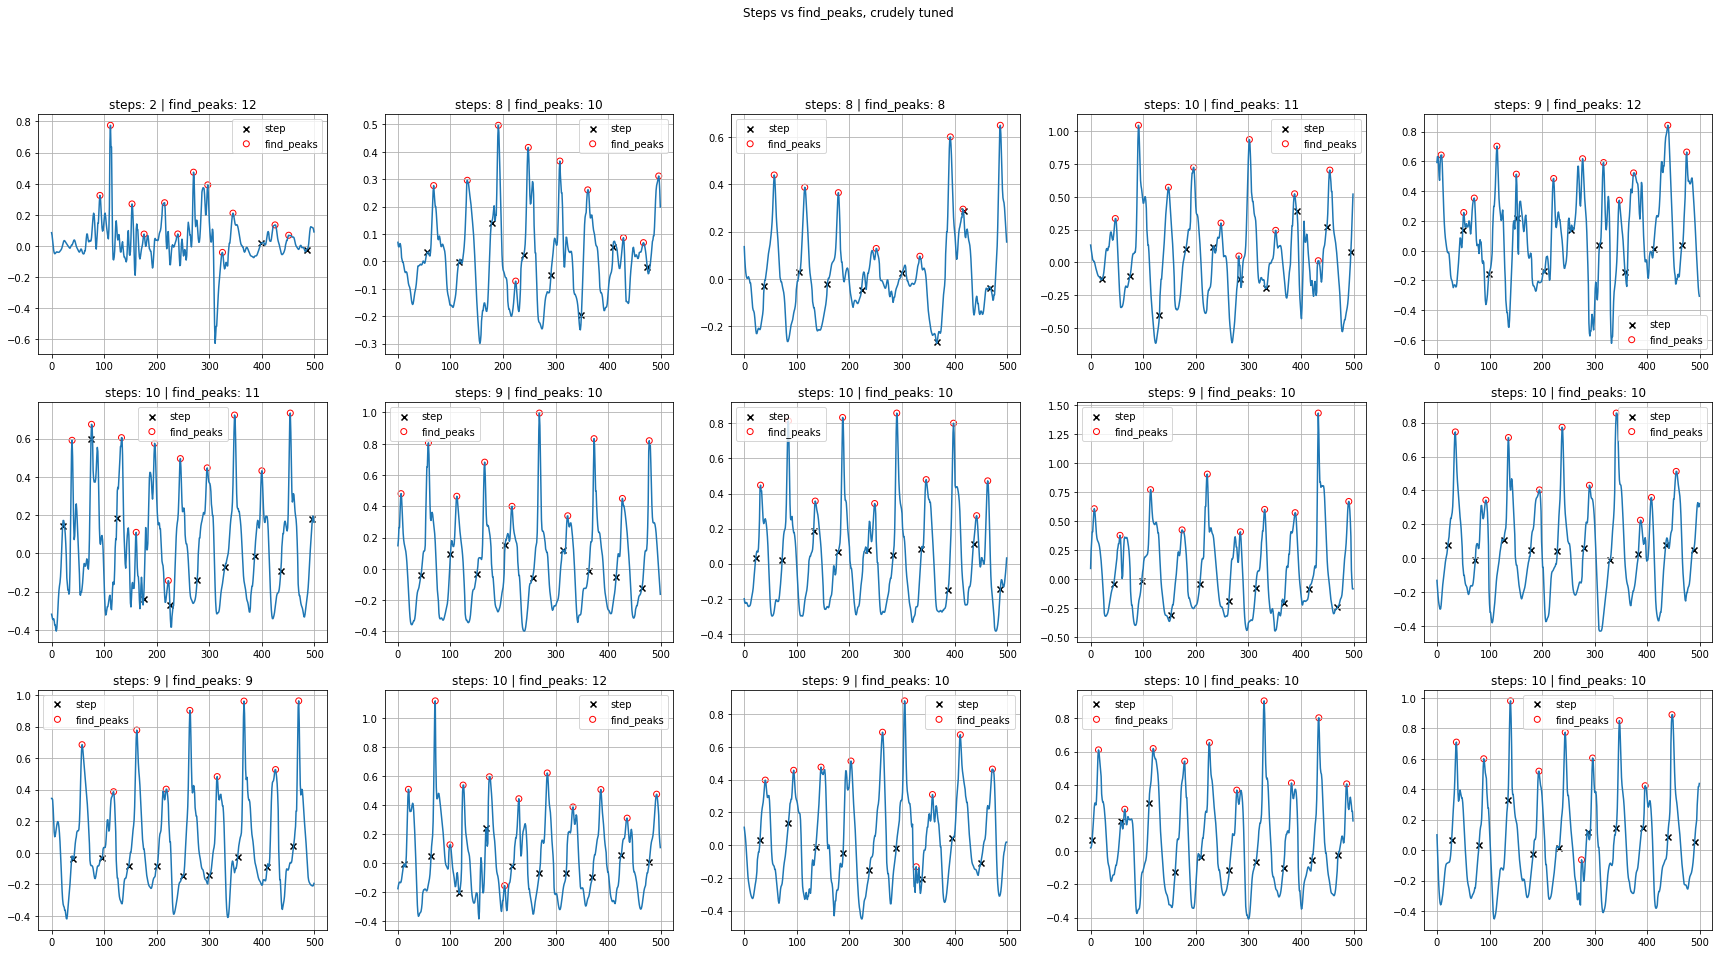

In [12]:
NFIGS = 15
fig, axs = plt.subplots(ncols=NFIGS//3, nrows=3, figsize=(30, 15))
n = 0
for i, w in data.resample(f"{WINDOW_SEC}s"):
    if w['annotation'].sum() >= STEPTOL:
        plotw(
            w, axs.flat[n],
            lp=None,
            find_peaks=True,
            find_peaks_params={
                'distance': .2 * SAMPLE_RATE,  # 0.2s in ticks
                'prominence': .1
            }
        )
        n += 1
    if n >= NFIGS: break

fig.suptitle("Steps vs find_peaks, crudely tuned")
fig.show()

We get big improvements after tuning the peak finder.

A common signal processing technique is to filter out frequencies that are irrelevant for the task.
In activity recognition, a lowpass filter with 3Hz cutoff is commonly applied for walk analysis.

Let's apply a 5Hz lowpass filter. We use a looser cutoff as we might also want to capture running steps, for which 5Hz is a reasonable upper bound. 
For example, Usain Bolt's sprint frequency is around 4.3Hz: https://www.econathletes.com/post/math-for-sprinters-steps-per-second-and-stride-length.

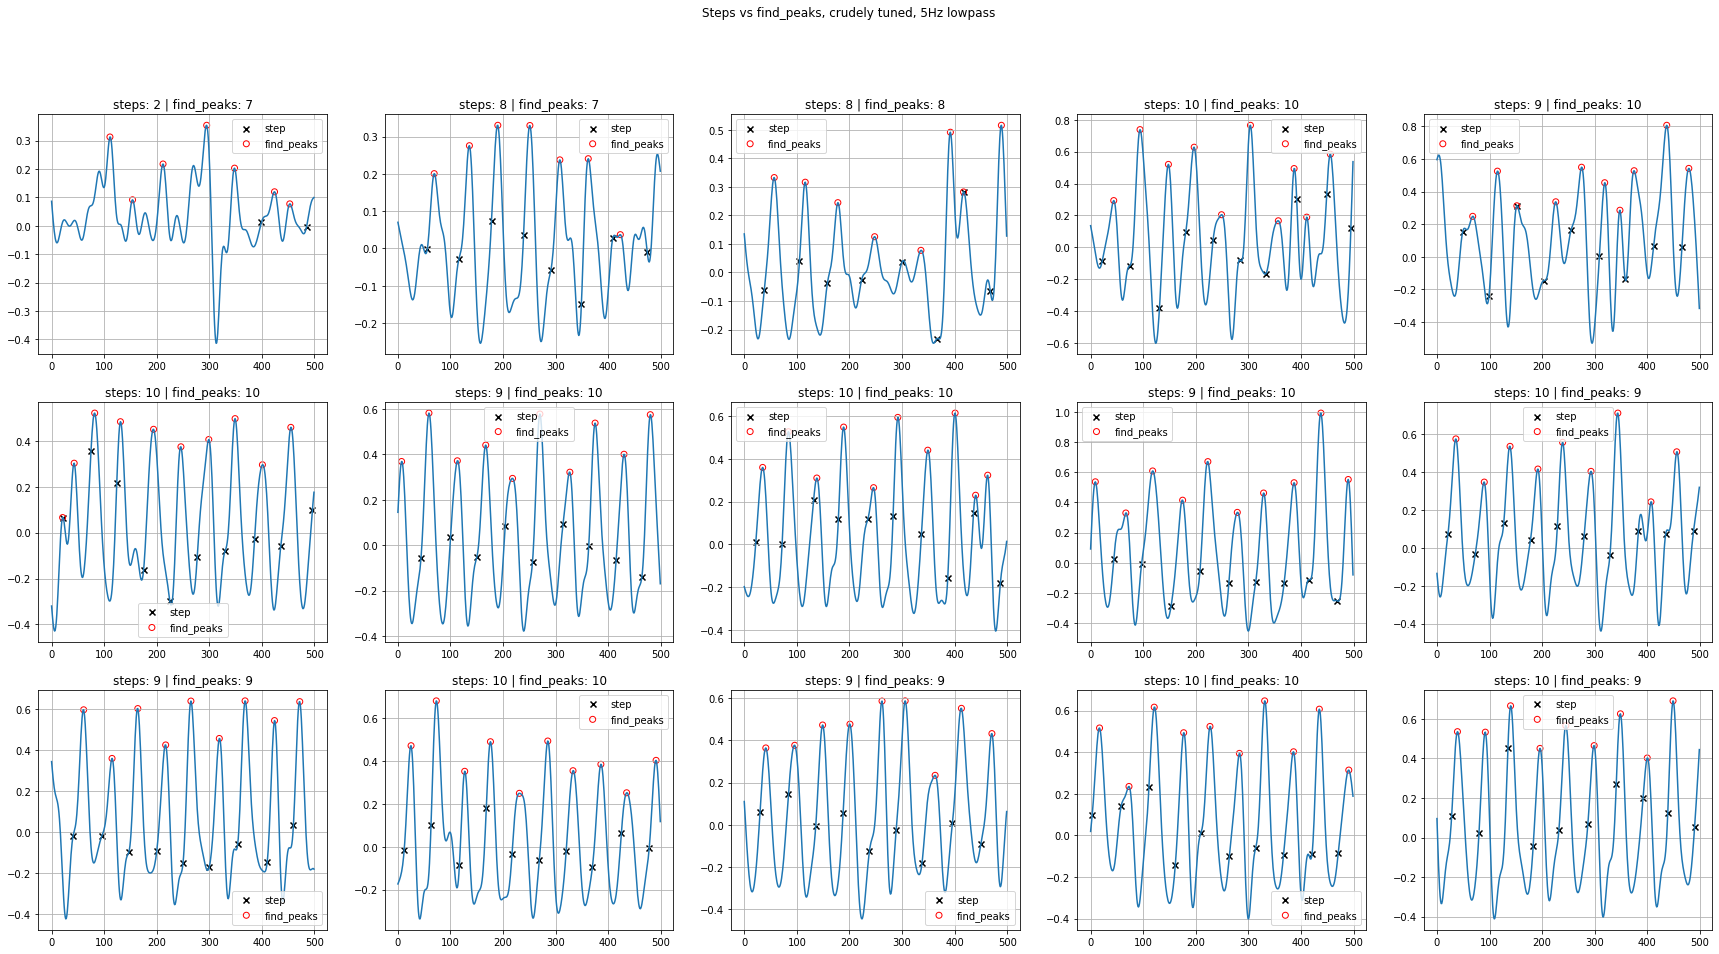

In [13]:
NFIGS = 15
fig, axs = plt.subplots(ncols=NFIGS//3, nrows=3, figsize=(30, 15))
n = 0
for i, w in data.resample(f"{WINDOW_SEC}s"):
    if w['annotation'].sum() >= STEPTOL:
        plotw(
            w, axs.flat[n], 
            lp=5,   # 5Hz lowpass cutoff
            find_peaks=True, 
            find_peaks_params={
                'distance': .2 * SAMPLE_RATE,   # 0.2s in ticks
                'prominence': .1
            }
        )
        n += 1
    if n >= NFIGS: break

fig.suptitle("Steps vs find_peaks, crudely tuned, 5Hz lowpass")
fig.show()

The filter clears out the signal making it easier to find peaks. The biggest
improvement is seen in the first figure where lots of false positives were
present before due to the high frequencies.

## End-to-end tuning

TODO